In [7]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import get_total_inhabitants_and_willingness, number_of_residents_in_detour, load_buurt_data, read_all_punt_to_punt, make_detour_matrix

In [8]:
punten = ['basis', 'bus', 'hbo_wo', 'highschool', 'ibis', 'mbo', 'trein']
modes = ['fiets', 'ebike']

matrix_data = read_all_punt_to_punt(punten, modes)


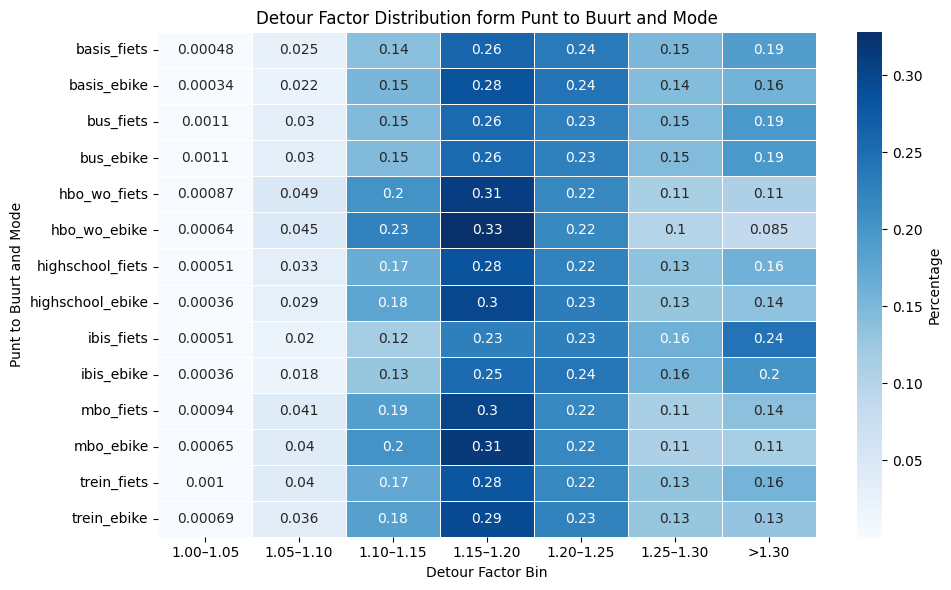

In [9]:
make_detour_matrix(matrix_data)

Loaded file from CSV


C:\Users\david\AppData\Local\Temp\ipykernel_29292\2125765406.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()


CSV saved → detour_trein_fiets.csv
                gm_naam  pop_weighted_detour
144               Hulst             2.431832
268           Terneuzen             2.012440
269        Terschelling             1.846487
296            Vlieland             1.801895
14              Ameland             1.627701
249     Schiermonnikoog             1.605260
231         Reimerswaal             1.604377
46              Borsele             1.598054
148             Kapelle             1.499319
102  Goeree-Overflakkee             1.456277
250  Schouwen-Duiveland             1.434147
103                Goes             1.433284
309           Waterland             1.394955
83        Edam-Volendam             1.392916
272              Tholen             1.382385
10               Almere             1.367893
255               Sluis             1.358277
199      Noord-Beveland             1.338373
173           Maasdriel             1.331790
270               Texel             1.326435


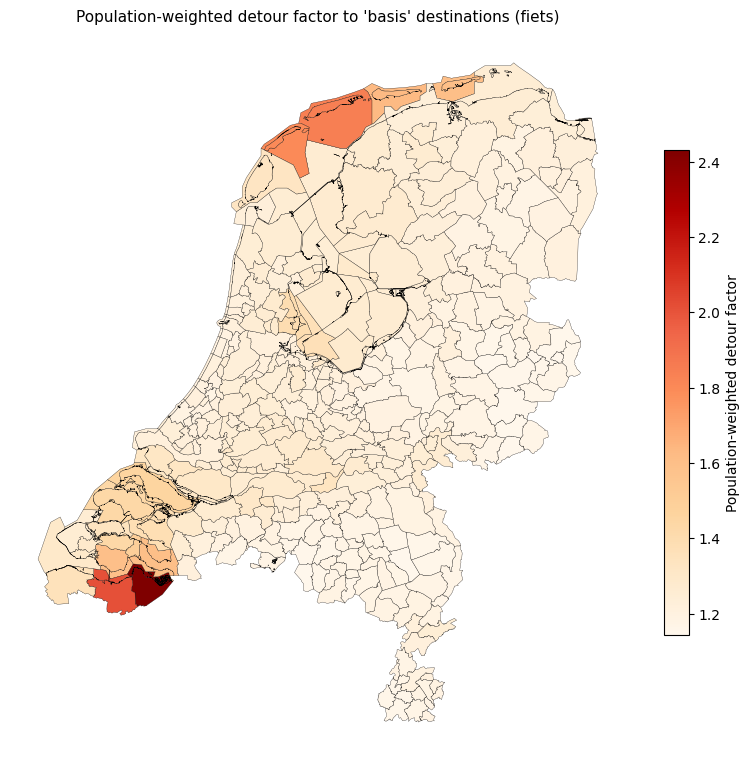

In [10]:


from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data.load_demographics import load_demograhics


# ─────────────────────────────────────────────────────────────────────────────
def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    """Return GeoDataFrame with columns ['gm_naam', 'geometry']."""
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    if "gemeentenaam" not in gdf.columns:
        raise ValueError("'gemeentenaam' column not found in 'gemeenten' layer")
    gdf = gdf[["gemeentenaam", "geometry"]].rename(columns={"gemeentenaam": "gm_naam"})
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf


def weighted_detour_by_municipality(trips: pd.DataFrame,
                                    demo:  pd.DataFrame) -> pd.DataFrame:
    """
    Population-weighted mean detour factor per municipality.
    Returns DataFrame ['gm_naam', 'pop_weighted_detour'].
    """
    merged = (
        trips.merge(
            demo[["gwb_code", "gm_naam", "a_inw"]],
            left_on="bu_code", right_on="gwb_code",
            how="left", validate="many_to_one")
          .dropna(subset=["a_inw"])
    )

    w = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()
                               / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    w["gm_naam"] = w["gm_naam"].str.title()
    return w


def main(
    category: str = "trein",
    modes: tuple[str, ...] = ("fiets",),
    gpkg:   Path = Path("data/wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("detour_result.csv"),
    top_n: int = 20,
    make_map: bool = True,
) -> None:
    # 1. load trip tables
    matrices = read_all_punt_to_punt([category], list(modes))
    if not matrices:
        raise FileNotFoundError("No matching punt→buurt files found")
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. load demographics & compute statistics
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"CSV saved → {out_csv}")
    print(det.nlargest(top_n, "pop_weighted_detour"))

    # 3. map
    if make_map:
        gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")
        ax = gdf.plot(
            column="pop_weighted_detour",
            cmap="OrRd",
            linewidth=0.2,
            edgecolor="black",
            figsize=(8, 10),
            legend=True,
            #make legend smaller
            legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
            missing_kwds={"color": "lightgrey", "label": "No data"},
        )
        ax.set_title(
            f"Population-weighted detour factor to '{category}' "
            f"destinations ({', '.join(modes)})",
            fontsize=11)
        ax.axis("off")
        plt.tight_layout()
        plt.savefig(
            f"Results/detour_map_{category}_{'_'.join(modes)}.png",
            dpi=300, bbox_inches="tight")
        plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# Auto-run in notebooks / IPython
if "__file__" not in globals():
    main(
        category="basis",
        modes=("fiets",),
        gpkg=Path("data/wijkenbuurten_2023_v2.gpkg"),
        out_csv=Path("detour_trein_fiets.csv"),
    )


## Calculate for popluation > value

Loaded file from CSV


C:\Users\david\AppData\Local\Temp\ipykernel_29292\2716919817.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())


Saved CSV → detour_result.csv


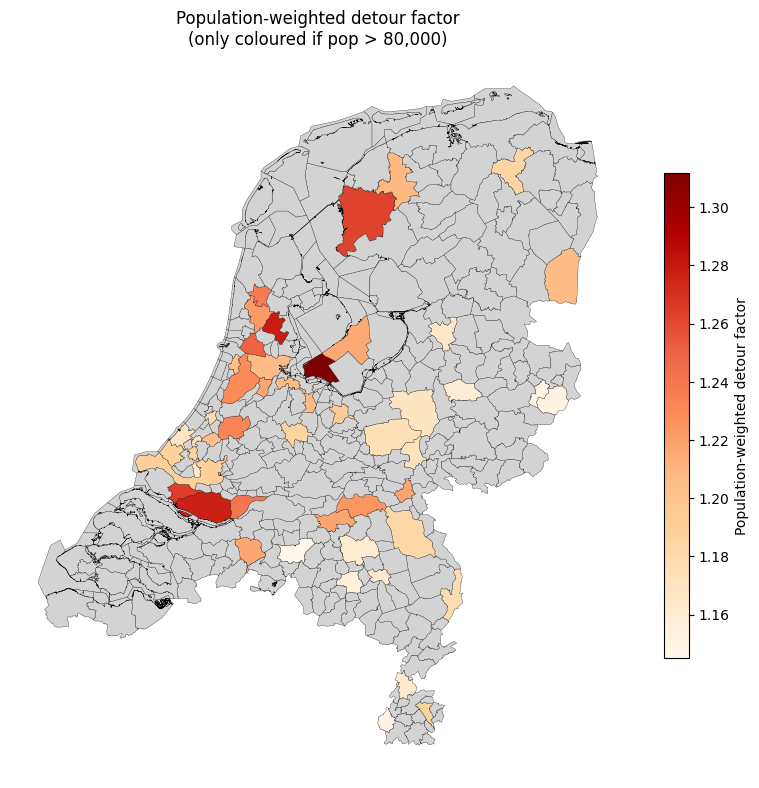

In [22]:
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data.load_demographics import load_demograhics

def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    gdf = (
        gdf[["gemeentenaam", "aantal_inwoners", "geometry"]]
        .rename(columns={"gemeentenaam": "gm_naam", "aantal_inwoners": "population"})
    )
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf

def weighted_detour_by_municipality(trips: pd.DataFrame, demo: pd.DataFrame) -> pd.DataFrame:
    merged = (
        trips
        .merge(demo[["gwb_code", "gm_naam", "a_inw"]],
               left_on="bu_code", right_on="gwb_code",
               how="left", validate="many_to_one")
        .dropna(subset=["a_inw"])
    )

    df_det = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    df_det["gm_naam"] = df_det["gm_naam"].str.title()
    return df_det

def plot_detour_map(gdf: gpd.GeoDataFrame, pop_thresh: int):
    # mask out those below threshold, but keep geometry
    gdf["plot_detour"] = gdf["pop_weighted_detour"].where(gdf["population"] > pop_thresh)

    ax = gdf.plot(
        column="plot_detour",
        cmap="OrRd",
        edgecolor="black",
        linewidth=0.2,
        figsize=(8, 10),
        legend=True,
        legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
        missing_kwds={"color": "lightgrey", "label": f"pop ≤ {pop_thresh:,}"},
    )
    ax.set_title(
        f"Population-weighted detour factor\n"
        f"(only coloured if pop > {pop_thresh:,})",
        fontsize=12
    )
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(
        f"Results/detour_map_{pop_thresh}.png",
        dpi=300, bbox_inches="tight")
    plt.show()

def main(
    category: str = "trein",
    modes: tuple[str, ...] = ("fiets",),
    gpkg: Path = Path("data/wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("detour_result.csv"),
    min_population: int = 80000,
):
    # 1. load and concat all punt→buurt files
    matrices = read_all_punt_to_punt([category], list(modes))
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. compute detour
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"Saved CSV → {out_csv}")

    # 3. load geometry and merge
    gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")

    # 4. plot with mask
    plot_detour_map(gdf, min_population)

# auto-run in notebook
if "__file__" not in globals():
    main()
